In [1]:
import xarray as xr
import numpy as np
import fsspec
from matplotlib import pyplot as plt

In [2]:
def makediag3d(M):
    b = np.zeros((M.shape[0], M.shape[1] * M.shape[1]))
    b[:, ::M.shape[1] + 1] = M
    return b.reshape(M.shape[0], M.shape[1], M.shape[1])

def get_starter_matrix(base_period_len, sample_count, frequencies_considered_count):
    nr = min(2 * frequencies_considered_count + 1,
                  sample_count)  # number of 2*+1 frequencies, or number of input images
    mat = np.zeros(shape=(nr, sample_count))
    mat[0, :] = 1
    ang = 2 * np.pi * np.arange(base_period_len) / base_period_len
    cs = np.cos(ang)
    sn = np.sin(ang)
    # create some standard sinus and cosinus functions and put in matrix
    i = np.arange(1, frequencies_considered_count + 1)
    ts = np.arange(sample_count)
    for column in range(sample_count):
        index = np.mod(i * ts[column], base_period_len)
        # index looks like 000, 123, 246, etc, until it wraps around (for len(i)==3)
        mat[2 * i - 1, column] = cs.take(index)
        mat[2 * i, column] = sn.take(index)

    return mat  

def HANTS(sample_count, inputs,
          frequencies_considered_count=3,
          outliers_to_reject='Hi',
          low=0., high=255,
          fit_error_tolerance=5,
          delta=0.1):
    """
    Function to apply the Harmonic analysis of time series applied to arrays
    sample_count    = nr. of images (total number of actual samples of the time series)
    base_period_len    = length of the base period, measured in virtual samples
            (days, dekads, months, etc.)
    frequencies_considered_count    = number of frequencies to be considered above the zero frequency
    inputs     = array of input sample values (e.g. NDVI values)
    ts    = array of size sample_count of time sample indicators
            (indicates virtual sample number relative to the base period);
            numbers in array ts maybe greater than base_period_len
            If no aux file is used (no time samples), we assume ts(i)= i,
            where i=1, ..., sample_count
    outliers_to_reject  = 2-character string indicating rejection of high or low outliers
            select from 'Hi', 'Lo' or 'None'
    low   = valid range minimum
    high  = valid range maximum (values outside the valid range are rejeced
            right away)
    fit_error_tolerance   = fit error tolerance (points deviating more than fit_error_tolerance from curve
            fit are rejected)
    dod   = degree of overdeterminedness (iteration stops if number of
            points reaches the minimum required for curve fitting, plus
            dod). This is a safety measure
    delta = small positive number (e.g. 0.1) to suppress high amplitudes
    """

    # define some parameters
    base_period_len = sample_count*2  #

    # check which setting to set for outlier filtering
    if outliers_to_reject == 'Hi':
        sHiLo = -1
    elif outliers_to_reject == 'Lo':
        sHiLo = 1
    else:
        sHiLo = 0

    nr = min(2 * frequencies_considered_count + 1,
             sample_count)  # number of 2*+1 frequencies, or number of input images

    # create empty arrays to fill
    outputs = np.zeros(shape=(inputs.shape[0], sample_count))

    mat = get_starter_matrix(base_period_len, sample_count, frequencies_considered_count)

    # repeat the mat array over the number of arrays in inputs
    # and create arrays with ones with shape inputs where high and low values are set to 0
    mat = np.tile(mat[None].T, (1, inputs.shape[0])).T
    p = np.ones_like(inputs)
    p[(low >= inputs) | (inputs > high)] = 0
    nout = np.sum(p == 0, axis=-1)  # count the outliers for each timeseries

    # prepare for while loop
    ready = np.zeros((inputs.shape[0]), dtype=bool)  # all timeseries set to false

    dod = 1  # (2*frequencies_considered_count-1)  # Um, no it isn't :/
    noutmax = sample_count - nr - dod
    # prepare to add delta to suppress high amplitudes but not for [0,0]
    Adelta = np.tile(np.diag(np.ones(nr))[None].T, (1, inputs.shape[0])).T * delta
    Adelta[:, 0, 0] -= delta
    
    for _ in range(sample_count):
        if ready.all():
            break
        # print '--------*-*-*-*',it.value, '*-*-*-*--------'
        # multiply outliers with timeseries
        za = np.einsum('ijk,ik->ij', mat, p * inputs)

        # multiply mat with the multiplication of multiply diagonal of p with transpose of mat
        diag = makediag3d(p)
        A = np.einsum('ajk,aki->aji', mat, np.einsum('aij,jka->ajk', diag, mat.T))
        # add delta to suppress high amplitudes but not for [0,0]
        A += Adelta
        #A[:, 0, 0] = A[:, 0, 0] - delta

        # solve linear matrix equation and define reconstructed timeseries
        zr = np.linalg.solve(A, za)
        outputs = np.einsum('ijk,kj->ki', mat.T, zr)

        # calculate error and sort err by index
        err = p * (sHiLo * (outputs - inputs))
        rankVec = np.argsort(err, axis=1, )

        # select maximum error and compute new ready status
        maxerr = np.max(err, axis=-1)
        #maxerr = np.diag(err.take(rankVec[:, sample_count - 1], axis=-1))
        ready = (maxerr <= fit_error_tolerance) | (nout == noutmax)

        # if ready is still false
        if not ready.all():
            j = rankVec.take(sample_count - 1, axis=-1)

            p.T[j.T, np.indices(j.shape)] = p.T[j.T, np.indices(j.shape)] * ready.astype(
                int)  #*check
            nout += 1

    return outputs

In [3]:
# Compute semi-random time series array with numb standing for number of timeseries
def array_in(numb):
    y = np.array([5.0, 2.0, 10.0, 12.0, 18.0, 23.0, 27.0, 40.0, 60.0, 70.0, 90.0, 160.0, 190.0,
                  210.0, 104.0, 90.0, 170.0, 50.0, 120.0, 60.0, 40.0, 30.0, 28.0, 24.0, 15.0,
                  10.0])
    y = np.tile(y[None].T, (1, numb)).T
    kl = (np.random.randint(2, size=(numb, 26)) *
          np.random.randint(2, size=(numb, 26)) + 1)
    kl[kl == 2] = 0
    y = y * kl
    return y

In [4]:
url = 'https://github.com/gespinoza/hants/raw/master/example/ndvi_probav.nc'
with fsspec.open(url) as fobj:
    ds = xr.open_dataset(fobj)
    print(ds)

<xarray.Dataset>
Dimensions:          (latitude: 26, longitude: 30, time: 363)
Coordinates:
  * latitude         (latitude) float64 11.48 11.47 11.47 ... 11.45 11.45 11.45
  * longitude        (longitude) float64 108.9 108.9 108.9 ... 108.9 108.9 108.9
  * time             (time) float64 2.015e+07 2.015e+07 ... 2.016e+07 2.016e+07
Data variables:
    crs              int32 ...
    code             (latitude, longitude) float64 ...
    outliers         (latitude, longitude, time) float64 ...
    original_values  (latitude, longitude, time) float64 ...
    hants_values     (latitude, longitude, time) float64 ...
    combined_values  (latitude, longitude, time) float64 ...


/Users/mattijnvanhoek/miniconda3/envs/gdal3/lib/python3.8/site-packages/h5netcdf/core.py:769: FutureWarning: String decoding changed with h5py >= 3.0. See https://docs.h5py.org/en/latest/strings.html for more details. Currently backwards compatibility with h5py < 3.0 is kept by decoding vlen strings per default. This will change in future versions for consistency with h5py >= 3.0. To silence this warning set kwarg ``decode_vlen_strings=False``. Setting ``decode_vlen_strings=True`` forces vlen string decoding.
  warnings.warn(msg, FutureWarning, stacklevel=0)


(array([ 1492.,  6359., 13043., 12672.,  5431.,  2225.,   976.,   675.,
          634.,   953.]),
 array([-0.08      ,  0.02      ,  0.12      ,  0.22000001,  0.32000001,
         0.42000001,  0.52000001,  0.62000001,  0.72000001,  0.82000002,
         0.92000002]),
 <BarContainer object of 10 artists>)

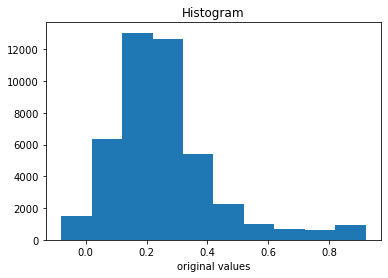

In [5]:
ds['original_values'].plot()

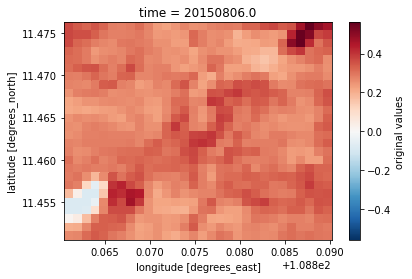

In [6]:
ds['original_values'][:,:,5].plot()

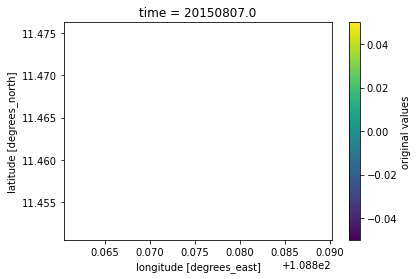

In [7]:
ds['original_values'][:,:,6].plot()

In [8]:
lenlat = ds.latitude.shape[0]
# replace in-place
vals = ds['original_values'].values
for m in range(lenlat):
    a = vals[m,:,:]
    # set nan to fill_val
    a[~np.isfinite(a)] = -9999.0
    
    b = HANTS(a.shape[-1], a, 6, outliers_to_reject='Lo', low=-2000, high=10000, fit_error_tolerance=500)
    
    vals[m,:,:] = b

(array([   477.,   2259.,  18499., 105296., 102144.,  28633.,  10914.,
          7961.,   6529.,    428.]),
 array([-0.14302016, -0.0513966 ,  0.04022696,  0.13185053,  0.22347409,
         0.31509766,  0.40672122,  0.49834478,  0.58996835,  0.68159191,
         0.77321548]),
 <BarContainer object of 10 artists>)

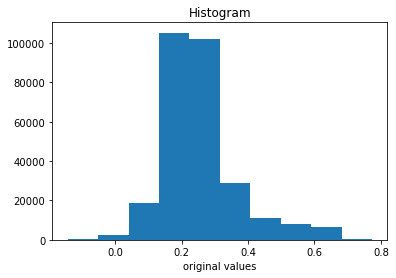

In [9]:
ds['original_values'].plot()

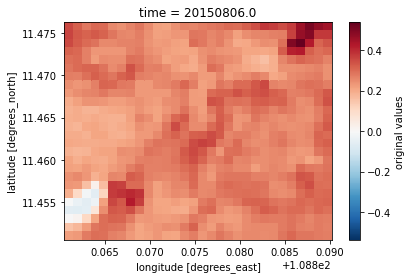

In [10]:
ds['original_values'][:,:,5].plot()

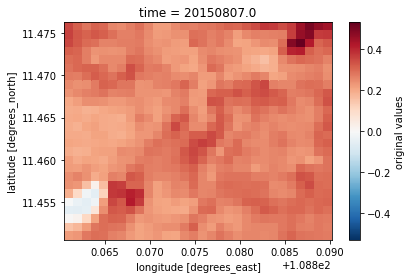

In [11]:
ds['original_values'][:,:,6].plot()